## Pytorch

In [ ]:
import os
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
x = torch.rand(2, 3)
y = torch.rand(3, 2)
x

tensor([[0.3008, 0.1641, 0.7855],
        [0.5500, 0.0087, 0.0132]])

In [ ]:
z = torch.empty(2, 2)
torch.mm(x, y, out = z)

tensor([[0.5422, 0.8660],
        [0.2927, 0.2583]])

In [ ]:
def relu_forward(x):
    return np.maximum(0,x)

assert torch.all(F.relu(x) == relu_forward(x))

In [ ]:
def elu_forward(x, alpha=0.01):
    m = x
    m = alpha*(torch.exp(m)-1)
    return torch.where(x>= 0, x, m)

assert torch.allclose(
    F.elu(x),
    elu_forward(x), 
    1e-4
)

In [ ]:
def lrelu_forward(x, alpha):
    return np.maximum(alpha * x, x)

assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

In [ ]:
def mish(x):
    return x*torch.tanh(torch.log(1+torch.exp(x)))

In [ ]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

In [ ]:
def swish(x):
    return x*torch.sigmoid(x)

In [ ]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

### Adam from scratch and linear regression (4 балла)




#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [ ]:

from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad():
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

In [ ]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
        super().__init__(params, defaults)

    def _group_step(self, group):
        # One group contains information about values passed in init
        # and model parameters to update
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']
        for param in filter(lambda x: x.grad is not None, group['params']):
            grad = param.grad.data
            state = self.state[param]
            if len(state) == 0:
                state['step'] = 0
                state['m'] = torch.zeros_like(param.data)
                state['v'] = torch.zeros_like(param.data)
            m, v = state['m'], state['v']
            state['step'] += 1
            m = torch.mul(m, beta_1) + (1 - beta_1) * grad
            v = torch.mul(v, beta_2) + (1 - beta_2) * (grad * grad)

            m_hat = m / (1 - np.power(beta_1, state['step']))
            v_hat = v / (1 - np.power(beta_2, state['step']))

            denom = v_hat.sqrt() + group['eps']
            param.data = param.data - lr * m_hat / denom     
         

### Xavier: 

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$


In [ ]:
n_input = 28 * 28
n_output = 10


weights = torch.tensor(
    torch.Tensor(n_input, n_output).uniform_(-1, 1) * math.sqrt(6. / (n_input + n_output)),
    requires_grad=True
)


bias = torch.randn((n_output,), requires_grad=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [ ]:
weights

tensor([[ 0.0586, -0.0805, -0.0569,  ...,  0.0824, -0.0701, -0.0846],
        [ 0.0480,  0.0374, -0.0166,  ...,  0.0127,  0.0336, -0.0344],
        [-0.0137,  0.0055,  0.0687,  ...,  0.0076,  0.0470, -0.0825],
        ...,
        [-0.0050,  0.0796, -0.0432,  ...,  0.0721, -0.0122, -0.0715],
        [ 0.0218, -0.0096,  0.0676,  ...,  0.0576, -0.0425,  0.0738],
        [ 0.0360, -0.0813, -0.0312,  ..., -0.0226, -0.0738,  0.0230]],
       requires_grad=True)

In [ ]:
optimizer = Adam([weights, bias], lr=0.0001)
loss = nn.CrossEntropyLoss()

Загрузим данные и создадим даталоадеры:

In [ ]:
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms


fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = DataLoader(
    fashion_mnist_train, batch_size=128, shuffle=True, num_workers=2
)

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

eval_dataloader = DataLoader(
    fashion_mnist_eval, batch_size=128, num_workers=2
)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
def train_logistic_regression(weights, bias, batch, loss, optimizer):
    batch_size = batch[0].shape[0]

    X = torch.reshape(batch[0], (batch_size, n_input,))
    y = batch[1]

    y_pred = torch.matmul(X, weights) + \
             bias.repeat(batch_size, 1)

    loss_value = loss(y_pred, y)

    loss_value.backward() 
    optimizer.step() 
    optimizer.zero_grad() 

    y_pred_class = torch.argmax(y_pred, dim=1)
    return {
        'loss': loss_value,
        'accuracy': (y_pred_class == y).float().mean()
    }

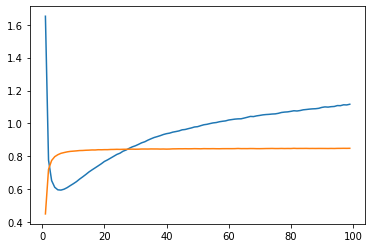

In [ ]:
%matplotlib inline
from IPython.display import clear_output


all_losses = []
all_accuracies = []
hl, = plt.plot([], [])

for epoch in range(1, 100):
    metrics_list = []
    for i, batch in enumerate(train_dataloader):
        metrics = train_logistic_regression(weights, bias, batch, loss, optimizer)
        metrics_list.append(metrics)
    all_losses.append(np.mean([float(metrics['loss']) for metrics in metrics_list]))
    all_accuracies.append(np.mean([float(metrics['accuracy']) for metrics in metrics_list]))


    clear_output(wait=True)
    plt.plot(np.arange(1, epoch + 1), all_losses)
    plt.plot(np.arange(1, epoch + 1), all_accuracies)
    plt.show()
    


Находя v, мы извлекаем корень из диагонали матрицы квадратов. Находя v_hat, мы делим на эти же квадраты. В зависимости от разброса, таким образом, мы либо получаем 1, либо меньше 1. Если без математики, оценка несмещенная, т. к. мы делаем корректировку на этот самый квадрат, и параметр стремится к генеральному.

Модель начала переобучаться, когда loss стал увеличиваться, а accuracy продолжила chilling at the local optima. У нас это в районе 10 эпохи. Происходить это может, в том числе, из-за lr - каждый batch немного "перетягивает" точность на себя, и в конце она очень "размазывается". 

### Neural

In [ ]:
def train_model(model, dataloader, optimizer, loss, device):
    model = model.train()

    total_loss = 0
    total_accuracy = 0
    num_batches = 0
    all_losses = []
    
   
    with tqdm(total=len(dataloader), file=sys.stdout) as prbar:
        for batch in dataloader:
            
            batch_size = batch[0].shape[0]
            X = batch[0]
            y = batch[1]

            y_pred = model(X)
            y_pred_class = torch.argmax(y_pred, dim=1)
          
            loss_value = loss(y_pred, y)
            

            loss_value.backward()
            optimizer.step()
            optimizer.zero_grad()

          
            metrics = {
                'loss': loss_value.detach().item(),
                'accuracy': (y_pred_class == y).float().mean()
            }

            prbar.set_description(
                f"Loss: {round(metrics['loss'], 4)} "
                f"Accuracy: {round(metrics['accuracy'].item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += metrics['loss']
            total_accuracy += metrics['accuracy']
            num_batches += 1
            all_losses.append(loss_value.detach().item())
    metrics = {
        'loss': total_loss / num_batches,
        'accuracy': total_accuracy / num_batches
    }
    
    return metrics


In [ ]:
# VGG-like: сверточные слои, потом полносвязные
class FirstModel(nn.Module):
    def __init__(self):
        super(FirstModel, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 5)
        # self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 256)
        # x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
# ResNet-like: сверточные слои с пробрасыванием, потом полносвязные
class SecondModel(nn.Module):
    def __init__(self):
        super(SecondModel, self).__init__()

        self.conv1 = nn.Conv2d(1, 3, 5, padding=1)
        self.conv2 = nn.Conv2d(3, 3, 3, padding=1)
        self.conv3 = nn.Conv2d(3, 3, 3, padding=1)
        self.conv4 = nn.Conv2d(3, 3, 3, padding=1)
        self.fc1 = nn.Linear(3 * 26 * 26, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x_0 = x
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x + x_0 
        x = x.view(-1, 3 * 26 * 26)
      
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

# только полносвязные    
third_model = nn.Sequential(
    Reshape(-1, 28 * 28),
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
)

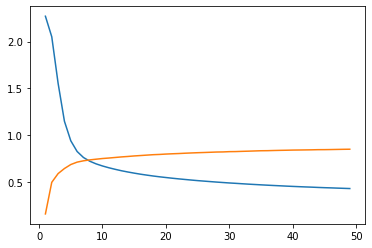

In [ ]:


def init_model(model, optimizer):
    if optimizer == "SGD":
      optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.00001)

    if optimizer == "RMSprop":
      optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00001)
    else:
      optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    loss = nn.CrossEntropyLoss() 
    return model, optimizer, loss

model, optimizer, loss = init_model(SecondModel(), "SGD")

all_losses = []
all_accuracies = []
hl, = plt.plot([], [])

for epoch in range(1, 50):
    metrics_list = []
    metrics = train_model(model=model.to(device=device), dataloader=train_dataloader, optimizer=optimizer, loss=loss, device=device)
    metrics_list.append(metrics)
    all_losses.append(np.mean([float(metrics['loss']) for metrics in metrics_list]))
    all_accuracies.append(np.mean([float(metrics['accuracy']) for metrics in metrics_list]))
    

    clear_output(wait=True)
    plt.plot(np.arange(1, epoch + 1), all_losses)
    plt.plot(np.arange(1, epoch + 1), all_accuracies)
    plt.show()


    



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

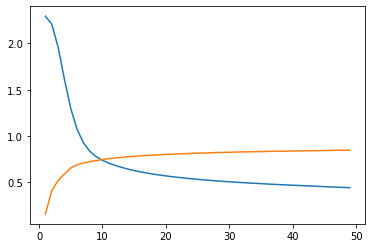

In [ ]:
model, optimizer, loss = init_model(SecondModel(), "RMSprop")


all_losses = []
all_accuracies = []
hl, = plt.plot([], [])

for epoch in range(1, 50):
    metrics_list = []
    metrics = train_model(model=model.to(device=device), dataloader=train_dataloader, optimizer=optimizer, loss=loss, device=device)
    metrics_list.append(metrics)
    all_losses.append(np.mean([float(metrics['loss']) for metrics in metrics_list]))
    all_accuracies.append(np.mean([float(metrics['accuracy']) for metrics in metrics_list]))
    

    clear_output(wait=True)
    plt.plot(np.arange(1, epoch + 1), all_losses)
    plt.plot(np.arange(1, epoch + 1), all_accuracies)
    plt.show()

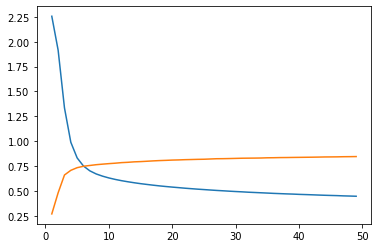

In [ ]:
model, optimizer, loss = init_model(SecondModel(), "Adam")


all_losses = []
all_accuracies = []
hl, = plt.plot([], [])

for epoch in range(1, 50):
    metrics_list = []
    metrics = train_model(model=model.to(device=device), dataloader=train_dataloader, optimizer=optimizer, loss=loss, device=device)
    metrics_list.append(metrics)
    all_losses.append(np.mean([float(metrics['loss']) for metrics in metrics_list]))
    all_accuracies.append(np.mean([float(metrics['accuracy']) for metrics in metrics_list]))
    

    clear_output(wait=True)
    plt.plot(np.arange(1, epoch + 1), all_losses)
    plt.plot(np.arange(1, epoch + 1), all_accuracies)
    plt.show()

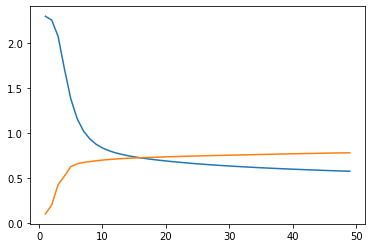

In [ ]:
model, optimizer, loss = init_model(FirstModel(), "SGD")
all_losses = []
all_accuracies = []
hl, = plt.plot([], [])
for epoch in range(1, 50):
    metrics_list = []
    metrics = train_model(model=model.to(device=device), dataloader=train_dataloader, optimizer=optimizer, loss=loss, device=device)
    metrics_list.append(metrics)
    all_losses.append(np.mean([float(metrics['loss']) for metrics in metrics_list]))
    all_accuracies.append(np.mean([float(metrics['accuracy']) for metrics in metrics_list]))
    clear_output(wait=True)
    plt.plot(np.arange(1, epoch + 1), all_losses)
    plt.plot(np.arange(1, epoch + 1), all_accuracies)
    plt.show()

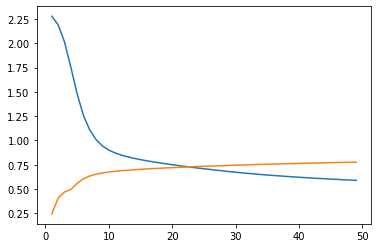

In [ ]:
model, optimizer, loss = init_model(FirstModel(), "RMSprop")
all_losses = []
all_accuracies = []
hl, = plt.plot([], [])
for epoch in range(1, 50):
    metrics_list = []
    metrics = train_model(model=model.to(device=device), dataloader=train_dataloader, optimizer=optimizer, loss=loss, device=device)
    metrics_list.append(metrics)
    all_losses.append(np.mean([float(metrics['loss']) for metrics in metrics_list]))
    all_accuracies.append(np.mean([float(metrics['accuracy']) for metrics in metrics_list]))
    clear_output(wait=True)
    plt.plot(np.arange(1, epoch + 1), all_losses)
    plt.plot(np.arange(1, epoch + 1), all_accuracies)
    plt.show()

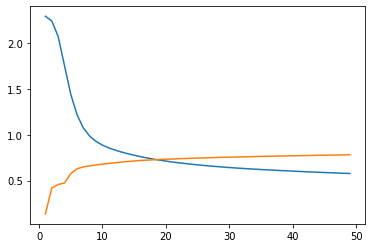

In [ ]:
model, optimizer, loss = init_model(FirstModel(), "Adam")
all_losses = []
all_accuracies = []
hl, = plt.plot([], [])
for epoch in range(1, 50):
    metrics_list = []
    metrics = train_model(model=model.to(device=device), dataloader=train_dataloader, optimizer=optimizer, loss=loss, device=device)
    metrics_list.append(metrics)
    all_losses.append(np.mean([float(metrics['loss']) for metrics in metrics_list]))
    all_accuracies.append(np.mean([float(metrics['accuracy']) for metrics in metrics_list]))
    clear_output(wait=True)
    plt.plot(np.arange(1, epoch + 1), all_losses)
    plt.plot(np.arange(1, epoch + 1), all_accuracies)
    plt.show()

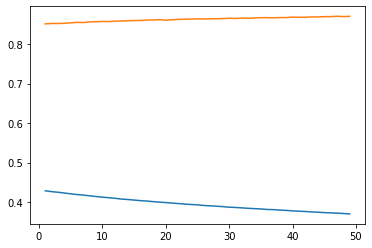

In [ ]:
init_model(third_model, "SGD")
all_losses = []
all_accuracies = []
hl, = plt.plot([], [])
for epoch in range(1, 50):
    metrics_list = []
    metrics = train_model(model=model.to(device=device), dataloader=train_dataloader, optimizer=optimizer, loss=loss, device=device)
    metrics_list.append(metrics)
    all_losses.append(np.mean([float(metrics['loss']) for metrics in metrics_list]))
    all_accuracies.append(np.mean([float(metrics['accuracy']) for metrics in metrics_list]))
    clear_output(wait=True)
    plt.plot(np.arange(1, epoch + 1), all_losses)
    plt.plot(np.arange(1, epoch + 1), all_accuracies)
    plt.show()

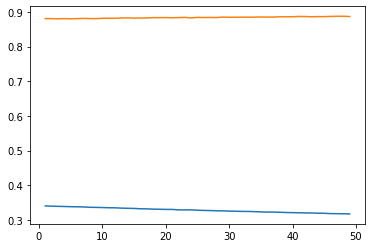

In [ ]:
init_model(third_model, "RMSprop")
all_losses = []
all_accuracies = []
hl, = plt.plot([], [])
for epoch in range(1, 50):
    metrics_list = []
    metrics = train_model(model=model.to(device=device), dataloader=train_dataloader, optimizer=optimizer, loss=loss, device=device)
    metrics_list.append(metrics)
    all_losses.append(np.mean([float(metrics['loss']) for metrics in metrics_list]))
    all_accuracies.append(np.mean([float(metrics['accuracy']) for metrics in metrics_list]))
    clear_output(wait=True)
    plt.plot(np.arange(1, epoch + 1), all_losses)
    plt.plot(np.arange(1, epoch + 1), all_accuracies)
    plt.show()

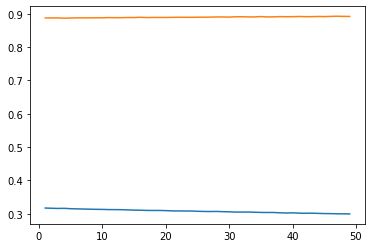

In [ ]:
init_model(third_model, "Adam")
all_losses = []
all_accuracies = []
hl, = plt.plot([], [])
for epoch in range(1, 50):
    metrics_list = []
    metrics = train_model(model=model.to(device=device), dataloader=train_dataloader, optimizer=optimizer, loss=loss, device=device)
    metrics_list.append(metrics)
    all_losses.append(np.mean([float(metrics['loss']) for metrics in metrics_list]))
    all_accuracies.append(np.mean([float(metrics['accuracy']) for metrics in metrics_list]))
    clear_output(wait=True)
    plt.plot(np.arange(1, epoch + 1), all_losses)
    plt.plot(np.arange(1, epoch + 1), all_accuracies)
    plt.show()

Моделью с лучшей точностью и наименьшей ошибкой оказалась модель с только полносвязными слоями. Это происходит, возможно, потому что мы не "играем" с частями изображений и никак их не преобразуем. Так, с примером отличия кота от собаки возникают трудности, если нам виден только кусок уха - вероятность ошибки здесь больше, чем только при применении полносвязных слоев. По тем же причинам, работают они медленнее, поэтому эффективнее применять свертки. Более того, полносвязные сети проще переобучаются. В целом, в нашем случае, лучше себя показала ResNet-like модель. Она обучается градиентным спуском со случайной инициализацией, что уменьшает ошибку и увеличивает точность. 

Что касается оптимизаторов, в среднем по графикам наиболее стабильный и высокий результат наблюдается с SGD with momentim, хоть разница между метриками и не слишком велика. В случае с Adam бывают "скачки" в точности, в случае RMSprop ошибка часто значительно выше других оптимизаторов. Достижение оптимума в SGD проимходит за счёт инерции и параметра затухания.